In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

# Leitura e preparação dos dados

In [2]:
ds = pd.read_csv("../datasets/EN_03_terciary_data.csv", sep = ";", index_col = 0)
ds.head()

,name,category,level,description,input,output,has_images,s_level,submissions,solved,ratio
1001,Extremely Basic,Beginner,5,"Read 2 variables, named A and B and make the s...",The input file will contain 2 integer numbers.,Print the letter X (uppercase) with a blank sp...,False,5 / 10,816938,236060,28.90%
1002,Area of a Circle,Beginner,5,The formula to calculate the area of a circumf...,The input contains a value of floating point (...,"Present the message ""A="" followed by the value...",False,5 / 10,650389,166254,25.56%
1003,Simple Sum,Beginner,2,"Read two integer values, in this case, the var...",The input file contains 2 integer numbers.,Print the variable SOMA with all the capital l...,False,2 / 10,313933,165940,52.86%
1004,Simple Product,Beginner,1,"Read two integer values. After this, calculate...",The input file contains 2 integer numbers.,"Print PROD according to the following example,...",False,1 / 10,238645,158387,66.37%
1005,Average 1,Beginner,4,Read two floating points' values of double pre...,The input file contains 2 floating points' val...,Print MEDIA(average in Portuguese) according t...,False,4 / 10,342625,136210,39.75%


In [3]:
ds = ds[["name", "description", "input", "output", "category", "level", "submissions", "solved"]]
ds["ratio"] = (ds["solved"] / ds["submissions"]).round(3)
ds.head()

,name,description,input,output,category,level,submissions,solved,ratio
1001,Extremely Basic,"Read 2 variables, named A and B and make the s...",The input file will contain 2 integer numbers.,Print the letter X (uppercase) with a blank sp...,Beginner,5,816938,236060,0.289
1002,Area of a Circle,The formula to calculate the area of a circumf...,The input contains a value of floating point (...,"Present the message ""A="" followed by the value...",Beginner,5,650389,166254,0.256
1003,Simple Sum,"Read two integer values, in this case, the var...",The input file contains 2 integer numbers.,Print the variable SOMA with all the capital l...,Beginner,2,313933,165940,0.529
1004,Simple Product,"Read two integer values. After this, calculate...",The input file contains 2 integer numbers.,"Print PROD according to the following example,...",Beginner,1,238645,158387,0.664
1005,Average 1,Read two floating points' values of double pre...,The input file contains 2 floating points' val...,Print MEDIA(average in Portuguese) according t...,Beginner,4,342625,136210,0.398


## Informações estatísticas

<Axes: xlabel='level', ylabel='ratio'>

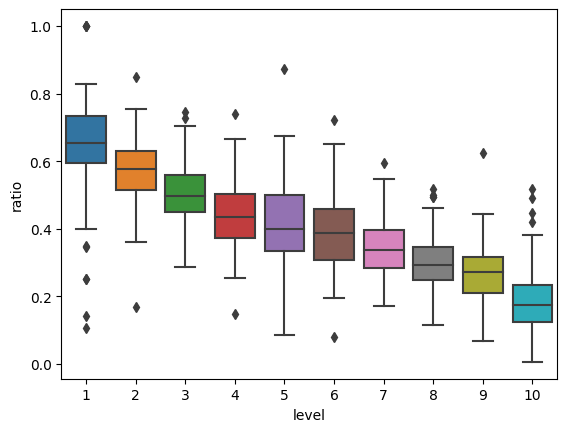

In [4]:
sns.boxplot(ds, x = "level", y = "ratio")

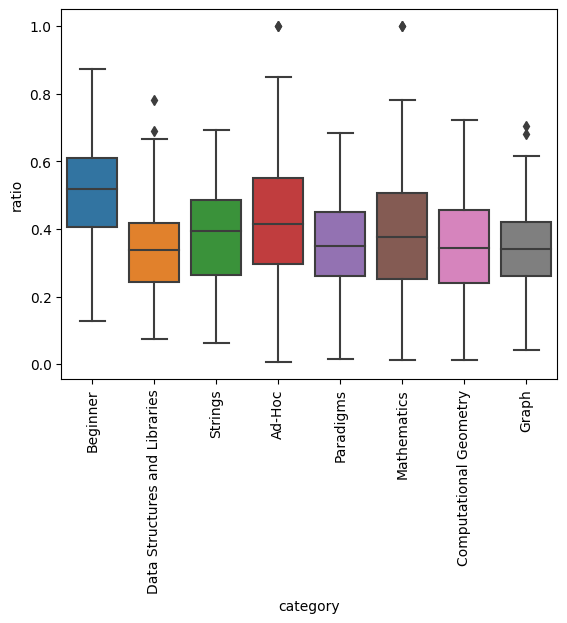

In [5]:
g = sns.boxplot(ds, x = "category", y = "ratio")
g.tick_params(axis='x', rotation=90)

In [6]:
ds[["level", "ratio"]].corr()

,level,ratio
level,1.000000,-0.803776
ratio,-0.803776,1.000000


In [7]:
ds[["level", "ratio"]].describe()

,level,ratio
count,1833.000000,1833.000000
mean,5.515548,0.404763
std,2.850899,0.166159
min,1.000000,0.006000
25%,3.000000,0.286000
50%,6.000000,0.392000
75%,8.000000,0.518000
max,10.000000,1.000000


## Definição do nível de dificuldade conforme a taxa de acerto (via regressão linear)

In [8]:
dsn_q1 = ds[["level", "ratio"]].groupby("level").quantile(0.25).copy()
dsn_q3 = ds[["level", "ratio"]].groupby("level").quantile(0.75).copy()

iqr = dsn_q3 - dsn_q1

dsn_q1 = (dsn_q1 - (1.5 * iqr))
dsn_q3 = (dsn_q3 + (1.5 * iqr))

dsn_q1 = dsn_q1.rename(columns = {"ratio": "ratio_inf"})
dsn_q3 = dsn_q3.rename(columns = {"ratio": "ratio_sup"})

dsn_qs = dsn_q1.join(dsn_q3)
dsn_qs

,ratio_inf,ratio_sup
level,,
1,0.388125,0.941125
2,0.342500,0.802500
3,0.284000,0.724000
4,0.178750,0.696750
5,0.084500,0.748500
6,0.080125,0.683125
7,0.119000,0.561000
8,0.103500,0.491500
9,0.048625,0.477625


### Remoção dos dados fora da amplitude interquartil

In [9]:
dsn = ds[["level", "ratio"]].copy().join(dsn_qs, on = ["level"])
dsn = dsn[(dsn["ratio"] <= dsn["ratio_sup"]) & (dsn["ratio"] >= dsn["ratio_inf"])]
dsn.head()

,level,ratio,ratio_inf,ratio_sup
1001,5,0.289,0.084500,0.748500
1002,5,0.256,0.084500,0.748500
1003,2,0.529,0.342500,0.802500
1004,1,0.664,0.388125,0.941125
1005,4,0.398,0.178750,0.696750


<Axes: xlabel='level', ylabel='ratio'>

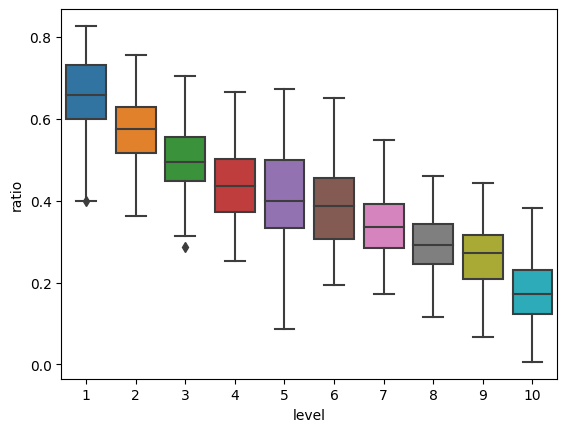

In [10]:
dsn = dsn[["level", "ratio"]]
sns.boxplot(dsn, x = "level", y = "ratio")

In [11]:
print("All size", ds.shape)
print("Train size", dsn.shape)
dsn.corr()

All size (1833, 9)
Train size (1804, 2)


,level,ratio
level,1.000000,-0.830722
ratio,-0.830722,1.000000


### Regressão linear e cálculo dos novos filtros (predict)

In [12]:
lr = LinearRegression().fit(dsn[["ratio"]], dsn["level"])
ds["n_level"] = lr.predict(ds[["ratio"]])
ds["n_level"] = ds["n_level"].clip(0, 10).round().astype(int)
ds.head()

,name,description,input,output,category,level,submissions,solved,ratio,n_level
1001,Extremely Basic,"Read 2 variables, named A and B and make the s...",The input file will contain 2 integer numbers.,Print the letter X (uppercase) with a blank sp...,Beginner,5,816938,236060,0.289,7
1002,Area of a Circle,The formula to calculate the area of a circumf...,The input contains a value of floating point (...,"Present the message ""A="" followed by the value...",Beginner,5,650389,166254,0.256,8
1003,Simple Sum,"Read two integer values, in this case, the var...",The input file contains 2 integer numbers.,Print the variable SOMA with all the capital l...,Beginner,2,313933,165940,0.529,4
1004,Simple Product,"Read two integer values. After this, calculate...",The input file contains 2 integer numbers.,"Print PROD according to the following example,...",Beginner,1,238645,158387,0.664,2
1005,Average 1,Read two floating points' values of double pre...,The input file contains 2 floating points' val...,Print MEDIA(average in Portuguese) according t...,Beginner,4,342625,136210,0.398,6


In [13]:
ds[["n_level", "ratio"]].corr()

,n_level,ratio
n_level,1.000000,-0.990343
ratio,-0.990343,1.000000


In [15]:
ds[["level", "n_level"]].corr()

,level,n_level
level,1.000000,0.800439
n_level,0.800439,1.000000


<Axes: xlabel='n_level', ylabel='ratio'>

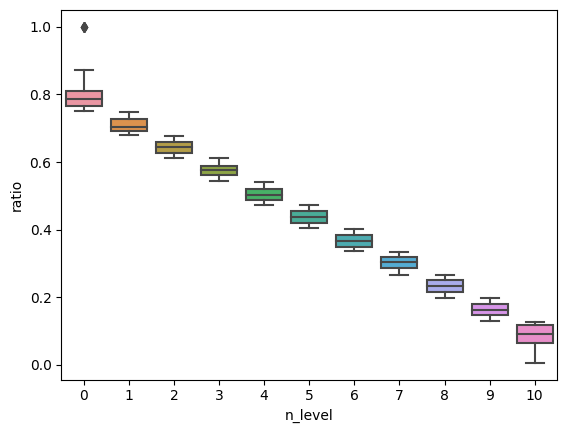

In [14]:
sns.boxplot(ds, x = "n_level", y = "ratio")

## Preprocessamento textual